# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: ARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}x_k + u_k + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=10Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./ARXsystem.jl"); using .ARXsystem

In [2]:
# Noise
sys_mnoise_sd = 1e-1;

# True coefficients
M_in = 1
M_out = 2
M = M_in + M_out
sys_coefficients = [0.0; rand(M) .- 0.5]

4-element Vector{Float64}:
  0.0
 -0.4509945936619607
 -0.36300963060262414
  0.34368853192071

In [3]:
# Time
N = 300
Δt = 0.05
time = range(0.0, step=Δt, length=N);

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*time) for i = 1:10]) ./ 10;

In [5]:
# Outputs

system = ARXsys(sys_coefficients, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in)

observations = zeros(N)
for k in 1:N
    ARXsystem.update!(system, controls[k])
    observations[k] = system.observation
end

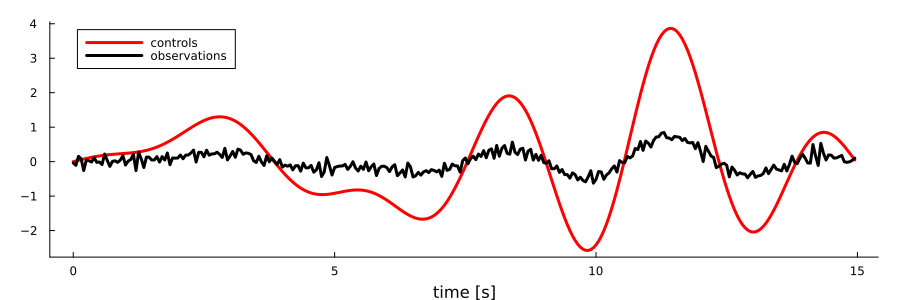

In [6]:
plot(xlabel="time [s]", size=(900,300))
plot!(time, controls, color="red", label="controls")
plot!(time, observations, color="black", label="observations")

## NARX model

In [7]:
# Polynomial degree
H = 1

# Delay order
Ly = 2
Lu = 1

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

In [8]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e-1, 1e-1)
pθ0 = MvNormalMeanCovariance(ones(M), 1e2diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 100.0 0.0; 0.0 0.0 0.0 100.0]
)


In [9]:
agent = NARXAgent(pθ0, pτ0, memory_actions=Lu, memory_senses=Ly, pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 100.0 0.0; 0.0 0.0 0.0 100.0]
)
, GammaShapeRate{Float64}(a=0.1, b=0.1), 10, 1, 2, 1, 4, [0.0, 0.0], [0.0])

## Parameter estimation

In [10]:
qθ = []
qτ = []

@showprogress for (k,t) in enumerate(time)
    
    NARXAgents.update!(agent, observations[k], controls[k])

    # Update beliefs
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [11]:
mθ = cat(mean.(qθ)...,dims=2)
vθ = cat( var.(qθ)...,dims=2)

4×300 Matrix{Float64}:
   0.95341    0.464437   0.439544   0.329102  …  0.00021166  0.000210415
 100.0       92.3191    60.6505    19.7213       0.0182342   0.0182289
 100.0      100.0       92.579     66.6393       0.0162288   0.0162284
 100.0       98.0034    95.133     88.7559       0.00158213  0.00158203

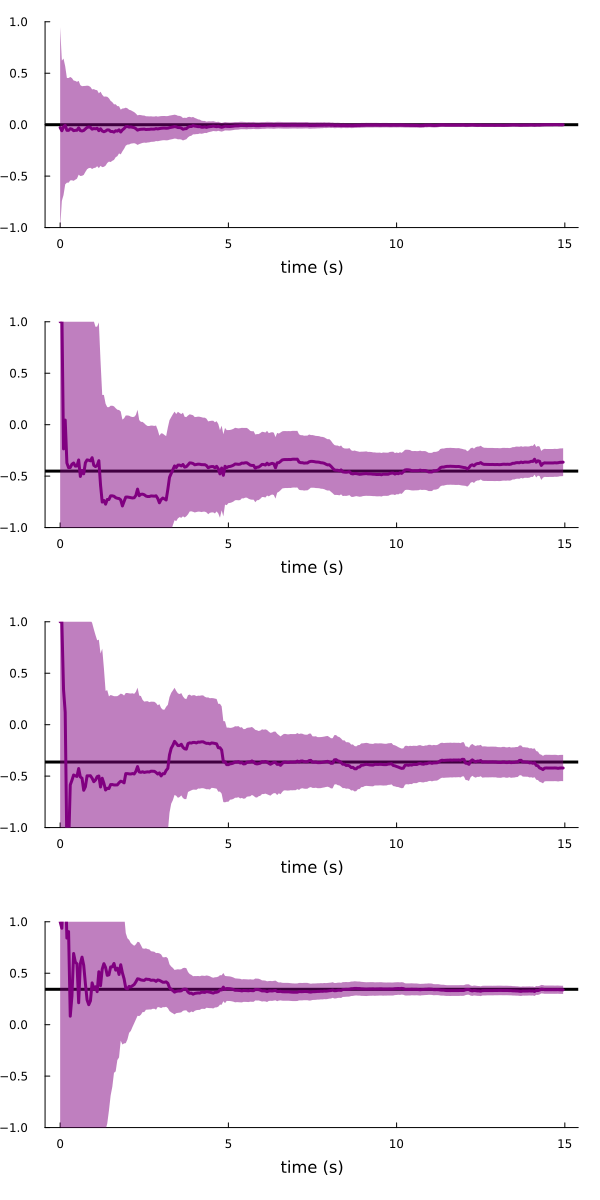

In [12]:
pw = []
for m in 1:M
    pwm = plot(xlabel="time (s)",ylims=(-1.,1.), size=(900,600))
    
    hline!([sys_coefficients[m]], color="black")
    plot!(time, mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple")
    
    push!(pw,pwm)
end
plot(pw..., layout=(4,1), size=(600,1200))